In [1]:
import sys,os
sys.path.append(os.path.abspath('../'))

In [2]:
from models.bert_lstm_crf import NERNetwork
from preprocess import create_dataloader, get_semeval_data
import json,os
import torch
import sklearn.preprocessing
from transformers import AutoTokenizer, AutoConfig
from utils import batch_to_device,compute_f1
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
device='cuda' if torch.cuda.is_available() else 'cpu'

def predict(model,test_dataloader,tag_encoder,device):
    if model.training:
        model.eval()
    
    predictions=[]
    for batch in tqdm(test_dataloader,total=len(test_dataloader),unit='batch'):
        batch=batch_to_device(inputs=batch,device=device)
        input_ids,attention_mask,token_type_ids = batch['input_ids'], batch['attention_mask'], batch['token_type_ids']
        with torch.no_grad():
            outputs=model.predict(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids)#(batch_size,seq_length,num_classes)

        for i,predict_tag_seq in enumerate(outputs):
            preds = tag_encoder.inverse_transform(predict_tag_seq)#(with wordpiece)
            preds = [prediction for prediction, offset in zip(preds.tolist(), batch.get('offsets')[i]) if offset]#offsets = [1] + offsets + [1]
            preds = preds[1:-1]
            #print(sum(attention_mask[i])-2,len(preds),preds)
            predictions.append(preds)
    
    return predictions


save_dir='../saved_models/bert-large-wwm-opener_en-Source/'

args=json.load(open(os.path.join(save_dir,'args_config.dict')))

tokenizer_parameters=json.load(open(os.path.join(args['model_name_or_path'],'tokenizer_config.json')))
transformer_tokenizer=AutoTokenizer.from_pretrained(args['model_name_or_path'],**tokenizer_parameters)
transformer_config=AutoConfig.from_pretrained(args['model_name_or_path'])

tag_complete=json.load(open(os.path.join(save_dir,'label.json'))).split(' ')
tag_encoder=sklearn.preprocessing.LabelEncoder()
tag_encoder.fit(tag_complete)
tag_outside='O'

n_tags=tag_encoder.classes_.shape[0]

class Args:
    def __init__(self) -> None:
        pass

args_=Args()
for k, v in args.items():
    args_.__setattr__(k,v)
print(args_.__dict__)
model=NERNetwork(config=args_,n_tags=n_tags)
success=model.load_state_dict(torch.load(f=os.path.join(save_dir,'pytorch_model.bin'),map_location='cpu'))
print(success)
model=model.to(device)
print(tag_encoder.classes_)

{'model_name_or_path': '/data/aisearch/nlp/data/xhsun/docker_run/semeval_dp/bert_large_wwm', 'file_path': '/data/aisearch/nlp/data/xhsun/docker_run/semeval_dp/bert_for_ner/data/opener_en', 'save_dir': '/data/aisearch/nlp/data/xhsun/docker_run/semeval_dp/bert_for_ner/saved_models/bert-large-wwm-opener_en-Source', 'ckpt': None, 'learning_rate': 3e-05, 'weight_decay': 1e-05, 'epochs': 30, 'train_batch_size': 64, 'gradient_accumulation_steps': 1, 'lstm_hidden_size': 150, 'test_batch_size': 64, 'max_grad_norm': 1, 'warmup_proportion': 0.1, 'max_len': 196, 'patience': 100, 'seed': 42, 'num_workers': 1, 'take_longest_token': False}
<All keys matched successfully>
['B-Source' 'I-Source' 'O']


In [3]:
test_conll_data=get_semeval_data(split='dev',dir='../data/opener_en',entity_idx=3)
test_dataloader=create_dataloader(sentences=test_conll_data.get('sentences'),
                                    tags=test_conll_data.get('tags'),
                                    transformer_tokenizer=transformer_tokenizer,
                                    transformer_config=transformer_config,
                                    max_len=args['max_len'],
                                    tag_encoder=tag_encoder,
                                    tag_outside=tag_outside,
                                    batch_size=32,
                                    num_workers=args['num_workers'],
                                    is_training=False)
predictions=predict(model=model,test_dataloader=test_dataloader,tag_encoder=tag_encoder,device=device)
f1=compute_f1(pred_tags=predictions,golden_tags=test_conll_data.get('tags'),from_test=True)

print("F1 score in test set is {}".format(f1))

  0%|          | 0/7 [00:00<?, ?batch/s]/home/cdou/anaconda3/lib/python3.8/site-packages/torchcrf/__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorCompare.cpp:255.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)
100%|██████████| 7/7 [00:04<00:00,  1.70batch/s]

              precision    recall  f1-score   support

      Source     0.6458    0.7949    0.7126        39

   micro avg     0.6458    0.7949    0.7126        39
   macro avg     0.6458    0.7949    0.7126        39
weighted avg     0.6458    0.7949    0.7126        39

F1 : 0.7126436781609194, accuracy : 0.9912369396697001, precision : 0.6458333333333334, recall : 0.7948717948717948
F1 score in test set is 0.7126436781609194


# plot confusion matrix

['B-Source', 'I-Source', 'O']
[[  31    0    8]
 [   0    0    1]
 [  17    0 2910]]


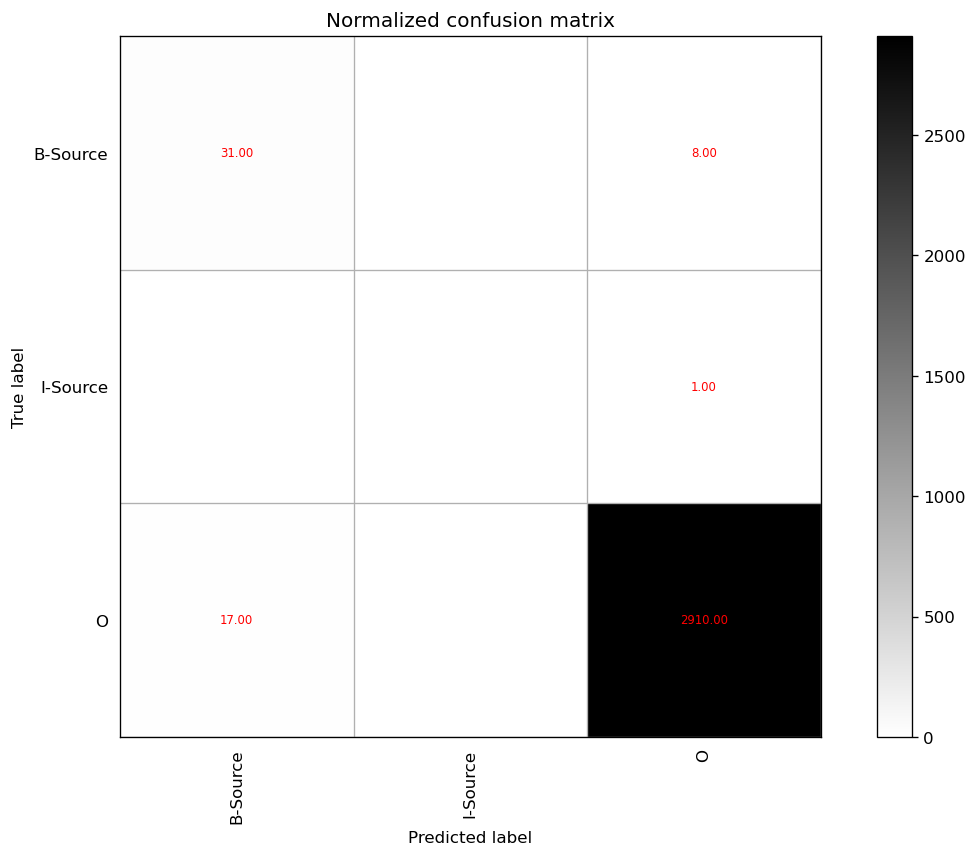

In [4]:
y_true=[]
for sen_tags in test_conll_data.get('tags'):
    y_true.append(tag_encoder.transform(sen_tags).tolist())
y_pred=[]
for sen_tags in predictions:
    y_pred.append(tag_encoder.transform(sen_tags).tolist())

labels=tag_encoder.classes_.tolist()
print(labels)

confusion_matrix_=np.zeros((tag_encoder.classes_.shape[0],tag_encoder.classes_.shape[0]),dtype=np.int32)
for golden,pred in zip(y_true,y_pred):
    assert len(golden)==len(pred)
    for g,p in zip(golden,pred):
        confusion_matrix_[g,p]+=1


np.set_printoptions(precision=2)
print(confusion_matrix_)
plt.figure(figsize=(12, 8), dpi=120)

ind_array = np.arange(len(labels))
x, y = np.meshgrid(ind_array, ind_array)

for x_val, y_val in zip(x.flatten(), y.flatten()):
    c = confusion_matrix_[y_val][x_val]
    if c > 0.01:
        plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=7, va='center', ha='center')
# offset the tick
tick_marks = np.array(range(len(labels))) + 0.5
plt.gca().set_xticks(tick_marks, minor=True)
plt.gca().set_yticks(tick_marks, minor=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which='minor', linestyle='-')
plt.gcf().subplots_adjust(bottom=0.15)

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.binary):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels, rotation=90)
    plt.yticks(xlocations, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(confusion_matrix_, title='Normalized confusion matrix')
# show confusion matrix
plt.show()

In [5]:
print(len(test_conll_data.get('sentences')),len(y_true),len(y_pred))

198 198 198


In [6]:
f=open('../results/Source-dev.txt','w')
for i in range(len(y_true)):
    sentence=test_conll_data.get('sentences')[i]
    pred_ids=y_pred[i]
    golden_ids=y_true[i]
    assert len(sentence)==len(golden_ids)==len(pred_ids)
    golden_tags=tag_encoder.inverse_transform(golden_ids)
    pred_tags=tag_encoder.inverse_transform(pred_ids)
    for word,g_tag,p_tag in zip(sentence,golden_tags,pred_tags):
        f.write('\t'.join([word,g_tag,p_tag])+'\n')
    f.write('\n')
f.close()

In [7]:
tag_encoder.inverse_transform([2,4,4,2,0,7,8,4])

array(['B-polar_nega', 'I-Source', 'I-Source', 'B-polar_nega', 'B-Source',
       'I-polar_posi', 'O', 'I-Source'], dtype='<U12')